In [1]:
import sys
sys.path.insert(0, '../')
from util import util
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats.mstats import gmean
import seaborn as sns
import pandas as pd

Text(0.5,1,'Possible beta distributions')

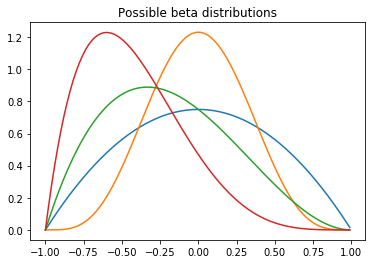

In [2]:
# plot the pdf within the range
x = np.arange (-1, 1, 0.01)

Y1 = st.beta(a = 2,b=2,loc=-1,scale=2)
z = Y1.pdf(x)
plt.plot(x,z)

Y2 = st.beta(a = 5,b=5,loc=-1,scale=2)
z = Y2.pdf(x)
plt.plot(x,z)

Y3 = st.beta(a = 2,b=3,loc=-1,scale=2)
z = Y3.pdf(x)
plt.plot(x,z)

Y4 = st.beta(a = 2,b=5,loc=-1,scale=2)
z = Y4.pdf(x)
plt.plot(x,z)
plt.title("Possible beta distributions")

In [3]:
def fit_beta(Y,n_samples,x_values,fit_type,support=(None,None),plot_observed=False,**kwargs):
    #fig, axs = plt.subplots(4,5, figsize=(15, 15), facecolor='w', edgecolor='k')
    #fig.subplots_adjust(hspace = .5, wspace=.001)
    fig, axs = plt.subplots(2,5, figsize=(12, 8), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()
    for i in range(10):
        S = Y.rvs(n_samples)
        for ele in fit_type:
            if ele.lower() == 'mle':
                beta_params = st.beta.fit(S)
                a,b,loc,scale = minimize(beta_loglikelihood,beta_params,args=(S),
                                    bounds=((1,None),(1,None),(support[0],support[0]),
                                           (support[1],support[1]))).x
                #a,b,loc,scale = st.beta.fit(S)
                fitted_beta = st.beta(a=a,b=b,loc=loc,scale=scale)

                #plt.hist(S,normed=True)

                y_values = fitted_beta.pdf(x_values)
            elif ele.lower() == 'kde':
                # fit a kde, optimising bandwidth
                fitted = st.gaussian_kde(S,bw_method='scott')
                y_values = fitted.pdf(x_values)
            elif ele.lower() == 'mse':
                params = st.beta.fit(S,**kwargs)
                a1,b1,loc1,scale1 = minimize(maximum_spacing,params,args=(S)).x
                fitted_beta = st.beta(a=a1,b=b1,loc=loc1,scale=scale1)
                y_values = fitted_beta.pdf(x_values)
            elif ele.lower() == 'ks':
                params = st.beta.fit(S)
                a,b,loc,scale = minimize(test_compute_kstest,params,args=(S),
                                    bounds=((1,None),(1,None),(support[0],support[0]),
                                           (support[1],support[1]))).x
                fitted_beta = st.beta(a=a,b=b,loc=loc,scale=scale)
                y_values = fitted_beta.pdf(x_values)
            else:
                raise ValueError("Not a valid estimation method")
            
            axs[i].plot(x_values, y_values,label=ele)
            
        if plot_observed:
            axs[i].hist(S,normed=True,label='Observed samples')
        axs[i].plot(x_values, Y.pdf(x_values),label='True pdf')
        axs[i].yaxis.set_visible(False)
    axs[i].legend()

In [4]:
def sampleSpacings(x):
    #calculates the sample spacings of X
    D=[xi-x[i] for i,xi in enumerate(x[1:])]
    return np.array(D)

def maximum_spacing(parameters,samples):
    # sort the samples
    orderedSample=np.sort(samples)
    
    # obtain the cdf of samples
    sample_cdf = st.beta.cdf(orderedSample,parameters[0],
                          parameters[1],parameters[2],parameters[3])
    # get the spacings
    spacings = sampleSpacings(sample_cdf)
    
    # we maximise (min) the (negative) log of geometric mean of spacing
    return -np.log(gmean(spacings))

In [5]:
from scipy.stats import kstest
def compute_kstest(parameters,samples):
    test = kstest(samples,'beta',args=parameters)
    return test[0]

def ecdf(x):
    # normalize X to sum to 1
    #x = x / np.sum(x)
    ys = np.arange(1, len(x)+1)/float(len(x))
    return ys

# my own implementation of the ks test statistic
# we sort the samples, 
# compute the cdf of those samples for a given beta
# compute  the empirical cdf
# take the maximum of the absolute difference of beta cdf and empirical cdf
def test_compute_kstest(parameters,samples,support=(None,None)):
    samples = np.sort(samples)
    if support[0] is not None:
        beta_cdf = st.beta.cdf(samples, parameters[0], parameters[1], 
                       loc=support[0], scale=support[1])
    else:
        beta_cdf = st.beta.cdf(samples, parameters[0], parameters[1], 
                       loc=parameters[2], scale=parameters[3])
    ecdf_result = ecdf(samples)
    ks_test = np.max(np.abs(ecdf_result-beta_cdf))
    #test = kstest(samples,'beta',args=parameters)
    return ks_test

In [6]:
def beta_loglikelihood(params,samples):
    log_pdf = st.beta.logpdf(samples, params[0], params[1], loc=params[2], scale=params[3])
    return -np.sum(log_pdf)

/usr/local/lib/python2.7/dist-packages/scipy/optimize/optimize.py:643: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/usr/local/lib/python2.7/dist-packages/scipy/stats/_continuous_distns.py:427: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/usr/local/lib/python2.7/dist-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Text(0.5,1,'MLE and KS with fixed support')

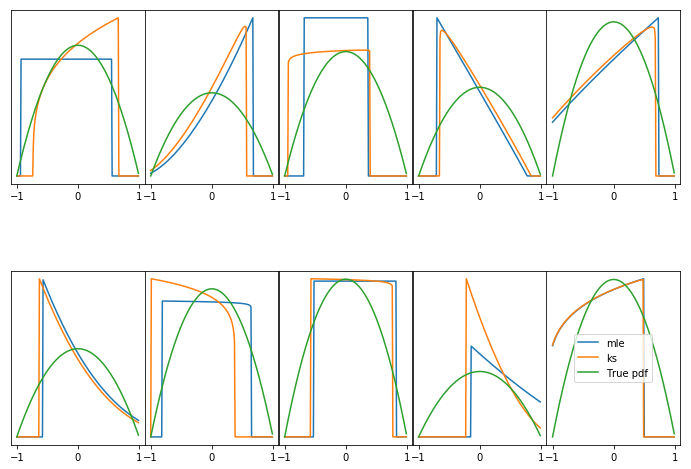

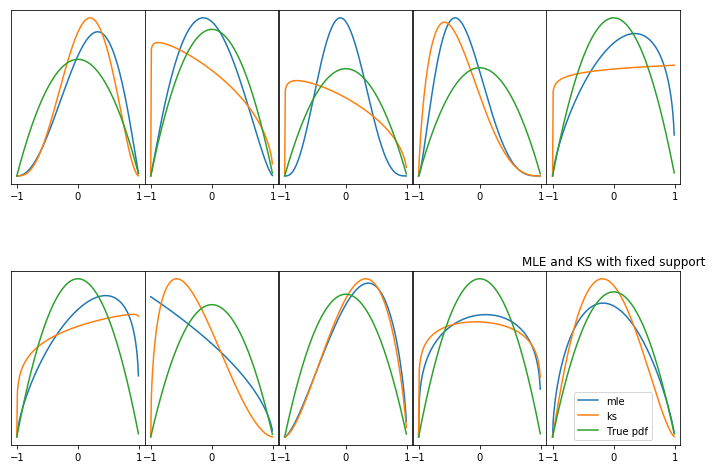

In [7]:
fit_beta(Y1,10,x,['mle','ks'])

fit_beta(Y1,10,x,['mle','ks'],support=(-1,2))
plt.title("MLE and KS with fixed support")

In [8]:
# simple quadratic cost function
# f1 = lambda x,y: -x*y + 0.2*x**2 
f1 = lambda x,y: -x*y + 5*x**2 + 2*x 

f3 = lambda x,y: 3*x**2 + 6*x*y**2 - 2*x**2*y - 7*x*y

f2 = lambda x,y: -x*y + 0.2*x**2

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [10]:
def minimise_dist(distribution,function,n_samples=10000):
    # minimises a cost function according to a given distribution
    samples = distribution.rvs(size=n_samples)
    
    # minimise the cost function
    res = minimize(function,0.0,args=(samples))
    return res.x

In [11]:
# concave function in x
f1_mean = lambda x,y: np.mean(f1(x,y),axis=0)
f2_mean = lambda x,y: np.mean(f2(x,y),axis=0)
f3_mean = lambda x,y: np.mean(f3(x,y),axis=0)

In [12]:
def mle(S,function,beta_params,initial_xstar,n_samples,support=(None,None)):
    
    if support[0] is not None:
        a,b,loc,scale = st.beta.fit(S,floc=support[0],fscale=support[1])
    else:
        a,b,loc,scale = minimize(beta_loglikelihood,beta_params,args=(S),
                                bounds=((1,None),(1,None),(support[0],support[0]),
                                       (support[1],support[1]))).x
    fitted_beta = st.beta(a=a,b=b,loc=loc,scale=scale)
    samples = fitted_beta.rvs(size=n_samples)
    res = minimize(function,initial_xstar,args=(samples))

    return res.x[0]

In [13]:
def kde(S,function,initial_xstar,n_samples):
 # fit distribution using kde
    fitted = st.gaussian_kde(S,bw_method='scott')
    samples = fitted.resample(size=n_samples)
    res = minimize(function,initial_xstar,args=(np.reshape(samples,(-1))))
    return res.x[0]

In [14]:
def mse(S,function,beta_params,initial_xstar,n_samples,support=(None,None)):
    # fit distribution using maximum spacing estimation
    a,b,loc,scale = minimize(maximum_spacing,beta_params,args=(S),
                                bounds=((1,None),(1,None),(support[0],support[0]),
                                       (support[1],support[1]))).x
    fitted_beta = st.beta(a=a,b=b,loc=loc,scale=scale)
    samples = fitted_beta.rvs(size=n_samples)
    res = minimize(function,initial_xstar,args=(samples))
    return res.x[0]

In [15]:
def ks(S,function,beta_params,initial_xstar,n_samples,support=(None,None)):
    
    if support[0] is not None:
        a,b = minimize(test_compute_kstest,beta_params[:2],args=(S,support),
                                bounds=((1,None),(1,None))).x
        loc = support[0]
        scale = support[1]
    else:
        a,b,loc,scale = minimize(test_compute_kstest,beta_params,args=(S),
                                bounds=((1,None),(1,None),(support[0],support[0]),
                                   (support[1],support[1]))).x
    fitted_beta = st.beta(a=a,b=b,loc=loc,scale=scale)
    
    samples = fitted_beta.rvs(size=n_samples)
    res = minimize(function,initial_xstar,args=(samples))
    return res.x[0]

In [16]:
def minimise_methods(distribution,function,method,N,n_iter=500,n_samples=7000):
    #results = np.zeros((len(method),n_iter,len(N)))
    results = pd.DataFrame(columns=['x_star','method','N','distribution'])
    #total = n_iter*len(distribution)*len(N)
    for j, dist in enumerate(distribution):
        many_samples = dist.rvs(n_samples)
        true_sol = minimize(function,0.0,args=(many_samples)).x[0]
        for m in range(len(N)):
            temp = {}
            temp['x_star']  = true_sol
            temp['N'] = N[m]
            temp['distribution'] = j
            temp['method'] = 'true'
            results = results.append(temp,ignore_index=True)
        for i in range(n_iter):
            for k in range(len(N)):
                temp = {}
                temp['distribution'] = j
                temp['N'] = N[k]
                # obtain the samples
                S = dist.rvs(N[k])
                beta_params = st.beta.fit(S,floc=-1,fscale=2)
                for l, ele in enumerate(method):
                    if ele == 'saa':
                        # maximise using SAA
                        SAA_xstar = minimize(function,0.0,args=(S)).x[0]
                        temp['x_star'] = SAA_xstar
                    elif ele == 'mle':
                        temp['x_star'] = mle(S,function,beta_params,SAA_xstar,n_samples)
                    elif ele == 'kde':
                        temp['x_star'] = kde(S,function,SAA_xstar,n_samples)
                    elif ele == 'mse':
                        temp['x_star'] = mse(S,function,beta_params,SAA_xstar,n_samples)
                    elif ele == 'mle_fixed':
                        temp['x_star'] = mle(S,function,beta_params,
                                               SAA_xstar,n_samples,support=(-1,2))
                    elif ele == 'ks':
                        temp['x_star'] = ks(S,function,beta_params,SAA_xstar,n_samples)
                    elif ele == 'ks_fixed':
                        temp['x_star'] = ks(S,function,beta_params,SAA_xstar,
                                            n_samples,support=(-1,2))
                    else:
                        raise ValueError("Not a vlid method")
                    temp['method'] = ele
                    results = results.append(temp,ignore_index=True)
    return results

In [17]:
def plot_result(results,x_labels,plot_histogram=False,y_label='average expected cost'):
    #plt.figure(figsize=(10,5))
    if plot_histogram:
        for i in range(results.shape[0]):
            plt.hist(results[i,:,0],bins=30,normed=True,alpha=1.0/(i+1))
            plt.title("Distribution of x_star for N=25")
    else:
        mean=np.mean(results,axis=1)
        std=np.std(results,axis=1)
        width=0.05
        N = [10,25,50]
        #for i in range(results.shape[0]):
        for i in range(results.shape[-1]):
            plt.figure(figsize=(10,5))
        #sns.boxplot(x="no of samples", y="expected cost", hue="technique",
        #            data=results, palette="Set3")
            #for j in range(results.shape[0]):
            plt.boxplot(results[:,:,i].T)
            #plt.bar(np.arange(len(N))+width*i, mean[i]-min(mean[i]), 
            #        width,bottom=min(mean[i]),
            #       yerr=std[i])
            #plt.xticks(np.arange(len(N)) + width / 2, (N))
            #
            plt.xticks(np.arange(6)+1 + width / 2,
                       x_labels)
            plt.ylabel('Expected cost')
            plt.title("Expected cost for %s" %str(N[i]))
            plt.show()
            #plt.plot(N,mean[i])
            #plt.errorbar(N, mean[i], yerr=std[i],capsize=5)
        #plt.xlabel('No of samples')
        #
        #plt.legend(['SAA','MLE','KDE','MSE','fixed support MSE','KS'])

In [18]:
N = [10,25,50]
n_iter = 1000
n_samples = 7000
methods = ['saa','mle','ks','mle_fixed','ks_fixed']
distributions = [Y1,Y2,Y3,Y4]

## Results 2.1
These are the results for: <br>
            <center>$ 5x^2 -xy + 2x $</center>

Text(0.5,0,'y')

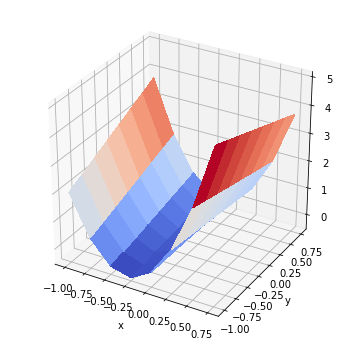

In [19]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-1, 1, 0.25)
Y = np.arange(-1, 1, 0.25)
X, Y = np.meshgrid(X, Y)
Z = f1(X,Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")

In [20]:
results1 = minimise_methods(distributions,f1_mean,methods,N,n_iter,n_samples)

/home/harrison/.local/lib/python2.7/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


In [21]:
def calculate_expected_cost(x_star_array,distribution,function,n_samples=10000):
    """
    we calculate the expected cost for a given x*, cost function and
    beta distribution using monte carlo
    """
    samples = distribution.rvs(n_samples)
    expected_cost = np.mean(function(np.reshape(x_star_array,(-1,1)),samples),axis=1)
    return np.reshape(expected_cost,x_star_array.shape)

In [22]:
def calculate_expected_cost_pandas(df,distributions,function,n_samples=10000):

    for i, ele in enumerate(distributions):
        mask = df['distribution']==i
        samples = ele.rvs(n_samples)
        func = lambda x: np.mean(function(x,samples))
        df.loc[mask,'expected_cost'] = df['x_star'].apply(func)
    return df

In [23]:
results1 = calculate_expected_cost_pandas(results1,
                                    distributions,f1)

In [24]:
results1.groupby(["distribution","N","method"]).mean()

x_star  expected_cost
distribution N  method                            
0            10 ks        -0.206795      -0.199082
                ks_fixed  -0.206231      -0.199140
                mle       -0.200076      -0.199458
                mle_fixed -0.200059      -0.199440
                saa       -0.199969      -0.199434
                true      -0.200751      -0.200470
             25 ks        -0.203001      -0.199953
                ks_fixed  -0.202703      -0.199971
                mle       -0.199706      -0.200056
                mle_fixed -0.199665      -0.200053
                saa       -0.199812      -0.200045
                true      -0.200751      -0.200470
             50 ks        -0.201559      -0.200226
                ks_fixed  -0.201417      -0.200234
                mle       -0.200064      -0.200270
                mle_fixed -0.200079      -0.200274
                saa       -0.200077      -0.200265
                true      -0.200751      -0.200470
1            10 ks        -0.204995      -0.198620
                ks_fixed  -0.204745      -0.198641
                mle       -0.200443      -0.198816
                mle_fixed -0.200338      -0.198821
                saa       -0.200344      -0.198819
                true      -0.199850      -0.199294
             25 ks        -0.201874      -0.199067
                ks_fixed  -0.201783      -0.199070
                mle       -0.199858      -0.199121
                mle_fixed -0.199850      -0.199121
                saa       -0.199874      -0.199121
                true      -0.199850      -0.199294
...                             ...            ...
2            25 ks        -0.222779      -0.240755
                ks_fixed  -0.222575      -0.240762
                mle       -0.220128      -0.240838
                mle_fixed -0.220126      -0.240838
                saa       -0.220144      -0.240835
                true      -0.220458      -0.241173
             50 ks        -0.221724      -0.240977
                ks_fixed  -0.221619      -0.240979
                mle       -0.220292      -0.241017
                mle_fixed -0.220285      -0.241018
                saa       -0.220322      -0.241016
                true      -0.220458      -0.241173
3            10 ks        -0.247268      -0.294253
                ks_fixed  -0.247207      -0.294246
                mle       -0.242660      -0.294358
                mle_fixed -0.242853      -0.294359
                saa       -0.242803      -0.294351
                true      -0.243028      -0.294878
             25 ks        -0.244720      -0.294644
                ks_fixed  -0.244653      -0.294646
                mle       -0.242843      -0.294683
                mle_fixed -0.242853      -0.294683
                saa       -0.242815      -0.294682
                true      -0.243028      -0.294878
             50 ks        -0.243959      -0.294756
                ks_fixed  -0.243910      -0.294759
                mle       -0.243035      -0.294778
                mle_fixed -0.243051      -0.294777
                saa       -0.242992      -0.294777
                true      -0.243028      -0.294878

[72 rows x 2 columns]

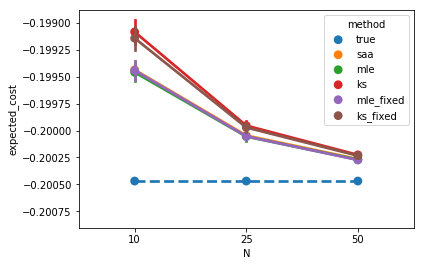

In [25]:
fig, ax = plt.subplots()
sns.pointplot(x="N", y="expected_cost", hue="method",
                data=results1[results1['distribution']==0],
             ax=ax,linestyles=['--']+['-']*5)

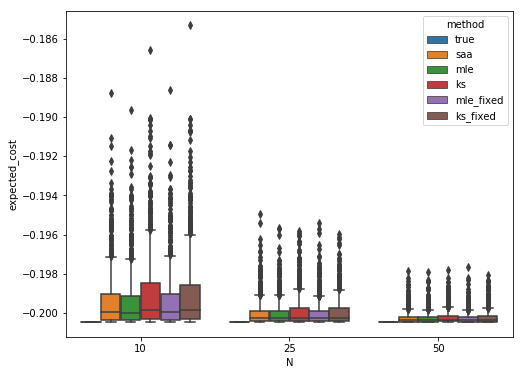

In [26]:
plt.figure(figsize=(8,6))
ax = sns.boxplot(x="N", y="expected_cost", hue="method",
                data=results1[results1['distribution']==0])

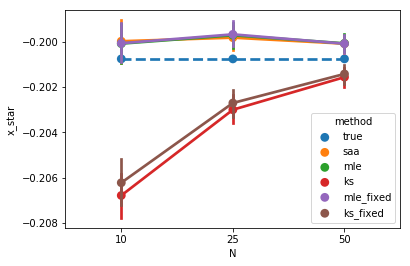

In [27]:
fig, ax = plt.subplots()
sns.pointplot(x="N", y="x_star", hue="method",
                data=results1[results1['distribution']==0],
             ax=ax,linestyles=['--']+['-']*5)

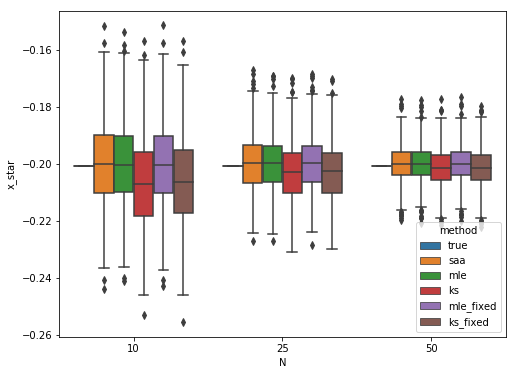

In [28]:
plt.figure(figsize=(8,6))
ax = sns.boxplot(x="N", y="x_star", hue="method",
                data=results1[results1['distribution']==0])

In [29]:
def plot_distribution_results(results,labels):
    width = 0.1  
    # no of distributions
    no_distribution = len(results)
    ind = np.arange(no_distribution)
    
    mean = np.mean(
        np.array([expected_cost1,expected_cost2,expected_cost3,expected_cost4]),axis=2)
    std = np.std(
        np.array([expected_cost1,expected_cost2,expected_cost3,expected_cost4]),axis=2)
    for i in range(std.shape[-1]):
        for j in range(std.shape[1]):
            plt.bar(ind+width*j, mean[:,j,i]+0.20, width,bottom=-0.20, label=labels[j],
                   yerr=std[:,j,i])
        plt.xticks(ind + width / 2, ('Y1', 'Y2', 'Y3', 'Y4'))
        plt.legend()
        plt.show()


## Results 2.2
These are the results for: <br>
            <center>$0.2x^2 -xy $</center>

Text(0.5,0,'y')

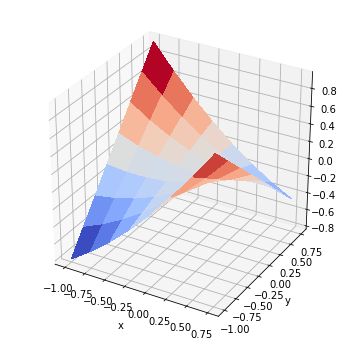

In [30]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-1, 1, 0.25)
Y = np.arange(-1, 1, 0.25)
X, Y = np.meshgrid(X, Y)
Z = f2(X,Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")

In [31]:
results2 = minimise_methods(distributions,f2_mean,methods,N,n_iter,n_samples)
results2 = calculate_expected_cost_pandas(results2,
                                    distributions,f2)

In [32]:
results2.groupby(["distribution","N","method"]).mean()

x_star  expected_cost
distribution N  method                            
0            10 ks        -0.178532       0.036742
                ks_fixed  -0.164479       0.035460
                mle       -0.000615       0.025149
                mle_fixed  0.001402       0.025464
                saa       -0.001524       0.025898
                true       0.005071      -0.000028
             25 ks        -0.070657       0.013129
                ks_fixed  -0.062390       0.012638
                mle        0.005270       0.009937
                mle_fixed  0.005528       0.009973
                saa        0.005356       0.010158
                true       0.005071      -0.000028
             50 ks        -0.036752       0.006605
                ks_fixed  -0.033658       0.006340
                mle        0.006116       0.005151
                mle_fixed  0.005013       0.005174
                saa        0.004682       0.005268
                true       0.005071      -0.000028
1            10 ks        -0.118399       0.014351
                ks_fixed  -0.112507       0.014051
                mle       -0.000885       0.010919
                mle_fixed  0.000344       0.010666
                saa        0.000287       0.010700
                true      -0.002502      -0.000011
             25 ks        -0.047059       0.005215
                ks_fixed  -0.044433       0.005152
                mle        0.002334       0.004461
                mle_fixed  0.003114       0.004451
                saa        0.002685       0.004446
                true      -0.002502      -0.000011
...                             ...            ...
2            25 ks        -0.563223      -0.038602
                ks_fixed  -0.558658      -0.038717
                mle       -0.498815      -0.040393
                mle_fixed -0.499372      -0.040435
                saa       -0.498410      -0.040320
                true      -0.503908      -0.048330
             50 ks        -0.539728      -0.043699
                ks_fixed  -0.538673      -0.043825
                mle       -0.508353      -0.044617
                mle_fixed -0.508290      -0.044613
                saa       -0.507363      -0.044574
                true      -0.503908      -0.048330
3            10 ks        -1.197337      -0.211614
                ks_fixed  -1.191205      -0.211969
                mle       -1.081914      -0.215541
                mle_fixed -1.085258      -0.215437
                saa       -1.083322      -0.215484
                true      -1.074220      -0.227198
             25 ks        -1.116858      -0.221364
                ks_fixed  -1.114152      -0.221454
                mle       -1.067309      -0.222297
                mle_fixed -1.067628      -0.222276
                saa       -1.067192      -0.222261
                true      -1.074220      -0.227198
             50 ks        -1.094521      -0.224061
                ks_fixed  -1.093978      -0.224077
                mle       -1.070527      -0.224617
                mle_fixed -1.070731      -0.224591
                saa       -1.070176      -0.224566
                true      -1.074220      -0.227198

[72 rows x 2 columns]

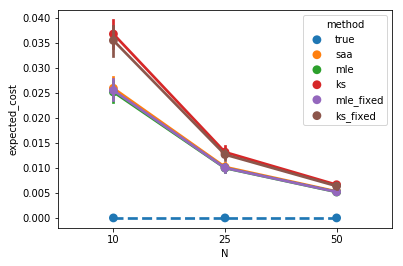

In [33]:
fig, ax = plt.subplots()
sns.pointplot(x="N", y="expected_cost", hue="method",
                data=results2[results2['distribution']==0],
             ax=ax,linestyles=['--']+['-']*5)

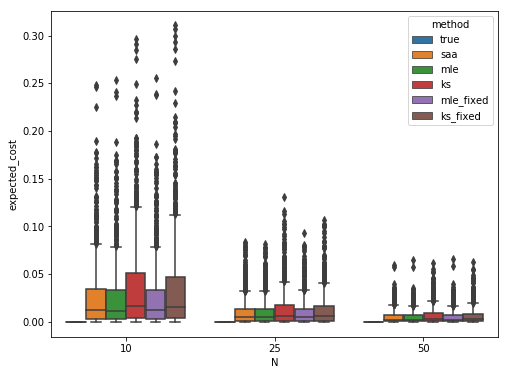

In [34]:
plt.figure(figsize=(8,6))
ax = sns.boxplot(x="N", y="expected_cost", hue="method",
                data=results2[results2['distribution']==0])

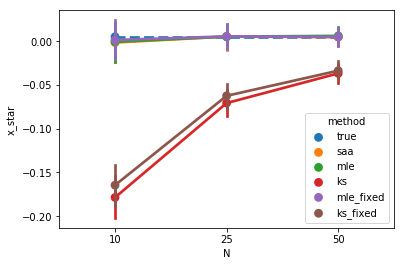

In [35]:
fig, ax = plt.subplots()
sns.pointplot(x="N", y="x_star", hue="method",
                data=results2[results2['distribution']==0],
             ax=ax,linestyles=['--']+['-']*5)

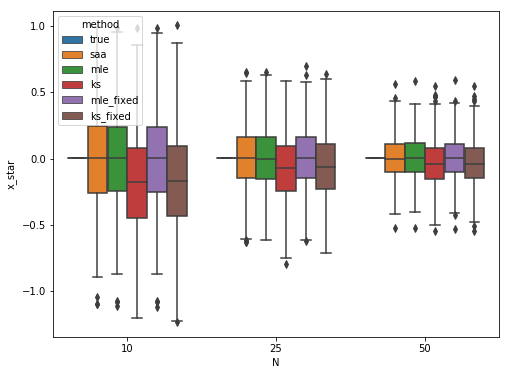

In [36]:
plt.figure(figsize=(8,6))
ax = sns.boxplot(x="N", y="x_star", hue="method",
                data=results2[results2['distribution']==0])

## Results
These are the results for: <br>
            <center>$ 3x^2 + 6xy^2 - 2x^2y - 7xy $</center>

Text(0.5,0,'y')

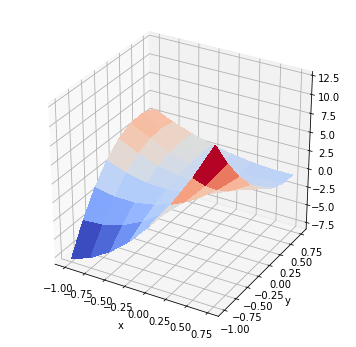

In [37]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-1, 1, 0.25)
Y = np.arange(-1, 1, 0.25)
X, Y = np.meshgrid(X, Y)
Z = f3(X,Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")

In [38]:
results3 = minimise_methods(distributions,f3_mean,methods,N,n_iter,n_samples)
results3 = calculate_expected_cost_pandas(results3,
                                    distributions,f3)

In [39]:
results3.groupby(["distribution","N","method"]).mean()

x_star  expected_cost
distribution N  method                            
0            10 ks        -0.260590       0.008543
                ks_fixed  -0.251424      -0.001466
                mle       -0.184967      -0.029215
                mle_fixed -0.185220      -0.027613
                saa       -0.192808      -0.024800
                true      -0.205458      -0.101632
             25 ks        -0.226519      -0.062030
                ks_fixed  -0.221711      -0.065634
                mle       -0.194034      -0.074910
                mle_fixed -0.194384      -0.074883
                saa       -0.197010      -0.073029
                true      -0.205458      -0.101632
             50 ks        -0.211560      -0.081889
                ks_fixed  -0.209763      -0.082951
                mle       -0.196778      -0.087268
                mle_fixed -0.197147      -0.087299
                saa       -0.198260      -0.086555
                true      -0.205458      -0.101632
1            10 ks        -0.130741       0.026001
                ks_fixed  -0.126415       0.024134
                mle       -0.079464       0.013603
                mle_fixed -0.077863       0.012723
                saa       -0.079582       0.012849
                true      -0.094034      -0.023126
             25 ks        -0.109182      -0.004085
                ks_fixed  -0.107997      -0.004344
                mle       -0.088822      -0.008060
                mle_fixed -0.088366      -0.008120
                saa       -0.089166      -0.007971
                true      -0.094034      -0.023126
...                             ...            ...
2            25 ks        -0.407602      -0.456996
                ks_fixed  -0.403623      -0.458833
                mle       -0.376169      -0.464564
                mle_fixed -0.375953      -0.464337
                saa       -0.377354      -0.463903
                true      -0.376481      -0.493155
             50 ks        -0.397695      -0.476142
                ks_fixed  -0.396071      -0.476433
                mle       -0.382794      -0.479623
                mle_fixed -0.383039      -0.479568
                saa       -0.383205      -0.478911
                true      -0.376481      -0.493155
3            10 ks        -0.663586      -1.390448
                ks_fixed  -0.659263      -1.392163
                mle       -0.604887      -1.403200
                mle_fixed -0.607813      -1.403176
                saa       -0.608086      -1.402750
                true      -0.608437      -1.454284
             25 ks        -0.630891      -1.429776
                ks_fixed  -0.628882      -1.430176
                mle       -0.607023      -1.433240
                mle_fixed -0.607691      -1.433213
                saa       -0.607388      -1.432788
                true      -0.608437      -1.454284
             50 ks        -0.620854      -1.442132
                ks_fixed  -0.619461      -1.442571
                mle       -0.609131      -1.443818
                mle_fixed -0.609119      -1.443803
                saa       -0.608739      -1.443540
                true      -0.608437      -1.454284

[72 rows x 2 columns]

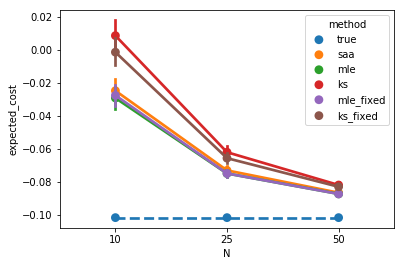

In [40]:
fig, ax = plt.subplots()
sns.pointplot(x="N", y="expected_cost", hue="method",
                data=results3[results3['distribution']==0],
             ax=ax,linestyles=['--']+['-']*5)

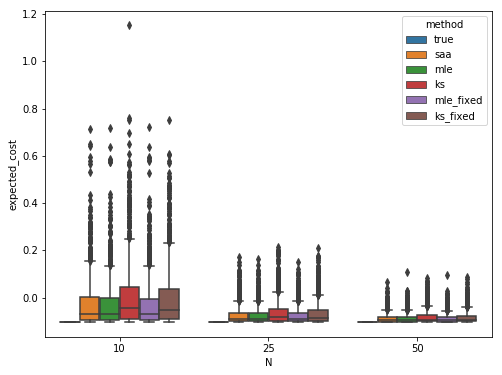

In [41]:
plt.figure(figsize=(8,6))
ax = sns.boxplot(x="N", y="expected_cost", hue="method",
                data=results3[results3['distribution']==0])

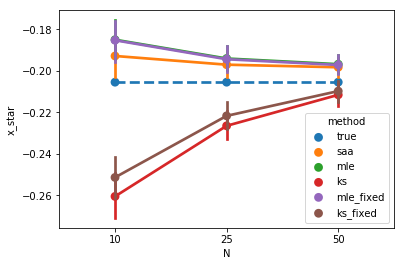

In [42]:
fig, ax = plt.subplots()
sns.pointplot(x="N", y="x_star", hue="method",
                data=results3[results3['distribution']==0],
             ax=ax,linestyles=['--']+['-']*5)

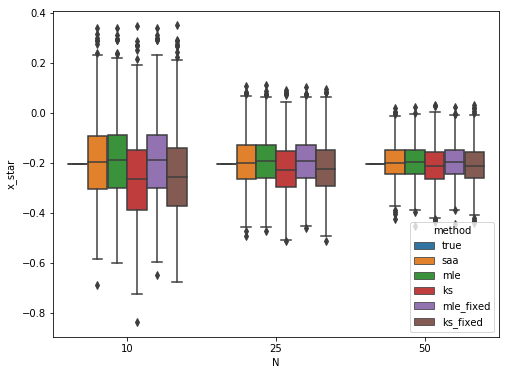

In [43]:
plt.figure(figsize=(8,6))
ax = sns.boxplot(x="N", y="x_star", hue="method",
                data=results3[results3['distribution']==0])

In [44]:
results1.to_csv("results1.csv")
results2.to_csv("results2.csv")
results3.to_csv("results3.csv")